# Requirements

- make sure you have Project.toml and Manifest.toml files in the working directory of the notebook
- set the directory containing source data files in next cell

In [1]:
## path to datasets
datadir = "../Datasets/"

"../Datasets/"

In [2]:
using CSV
using DataFrames
using LightGraphs
using Statistics
using GraphPlot
using PyPlot
using StatsBase
using GLM

Just looking at basic statistics on degree distribution, clustering coefficient and shortest paths, we can identify huge difference between different types of graphs. Here we look at a social-type graph, and a transportation-type (power grid) network.

## GitHub Developers (undirected)

Description

A large social network of GitHub developers which was collected from the public API in June 2019. Nodes are developers who have starred at least 10 repositories and edges are mutual follower relationships between them. The vertex features are extracted based on the location, repositories starred, employer and e-mail address. The task related to the graph is binary node classification - one has to predict whether the GitHub user is a web or a machine learning developer. This target feature was derived from the job title of each user.


In [3]:
## read the GitHub edge list into a graph
D = CSV.read(datadir * "GitHubDevelopers/musae_git_edges.csv", DataFrame) .+ 1
max_node_id = max(maximum(D.id_1), maximum(D.id_2))
gh = SimpleGraph(max_node_id)
foreach(row -> add_edge!(gh, row...), eachrow(D))

## add some node features, here there are
## 2 class of nodes, 0: web developer (red), 1: ml developer (blue)
X = CSV.read(datadir * "GitHubDevelopers/musae_git_target.csv", DataFrame)
X.id .+= 1
@assert extrema(diff(X.id)) == (1, 1) && extrema(X.id) == (1, length(vertices(gh)))
gh_target = X.ml_target
gh_color = ifelse.(X.ml_target .== 0, "grey", "black")
gh_lbl = ifelse.(X.ml_target .== 0, "web", "ml");

## Europe Electric Grid

Network of high voltage grid in Europe. Details at:
https://zenodo.org/record/47317#.Xt6nzy3MxTY



In [4]:
edge_list = split.(readlines(datadir * "GridEurope/gridkit_europe-highvoltage.edges"))
vertex_ids = unique(reduce(vcat, edge_list))
vertex_map = Dict(vertex_ids .=> 1:length(vertex_ids))
gr = SimpleGraph(length(vertex_ids))
foreach(((from, to),) -> add_edge!(gr, vertex_map[from], vertex_map[to]), edge_list)
X = CSV.read(datadir * "GridEurope/gridkit_europe-highvoltage.vertices", DataFrame)
X.id = [get(vertex_map, string(v), missing) for v in X.v_id]
dropmissing!(sort!(X, :id))
@assert extrema(diff(X.id)) == (1, 1) && extrema(X.id) == (1, length(vertices(gr)))
gr_longitude = X.lon
gr_latitude = X.lat
gr_type = X.typ;

## Features for 4 graphs

- GitHub
- GitHub ml developers
- GitHub web developers
- Grid

In [50]:
## for github, 9739 are ml developers, and 27961 are web developers;
## build the subgraphs
gh_ml = induced_subgraph(gh, findall(==("ml"), gh_lbl))[1]
gh_web = induced_subgraph(gh, findall(==("web"), gh_lbl))[1]

@show nv(gh_ml), nv(gh_web)

(nv(gh_ml), nv(gh_web)) = (9739, 27961)


(9739, 27961)

In [6]:
## github graph: count ml with connection to web only and vice-versa
c_ml, c_web = 0, 0
for v in vertices(gh)
    if gh_lbl[v] == "ml"
        if count(i -> gh_lbl[i] == "ml", neighbors(gh, v)) == 0
            c_ml += 1
        end
    else
        if count(i -> gh_lbl[i] == "web", neighbors(gh, v)) == 0
            c_web += 1
        end
    end
end
print("$c_ml ml connected only to web and $c_web web connected only to ml")

2308 ml connected only to web and 285 web connected only to ml

In [7]:
function igraph_diameter(G)
    ccs = connected_components(G)
    ccg = [induced_subgraph(G, cc)[1] for cc in ccs]
    maximum(maximum(maximum(gdistances(g, i)) for i in vertices(g)) for g in ccg)
end


igraph_diameter (generic function with 1 method)

In [8]:
## compute and store basic stats in a table

function baseStats(G)
    deg = degree(G)
    cc = connected_components(G)
    return Any[nv(G), ne(G),
            minimum(deg), mean(deg), median(deg), quantile(deg, 0.99), maximum(deg),
            length(cc), maximum(length, cc), count(==(0), deg),
            global_clustering_coefficient(G),
            mean(local_clustering_coefficient(G)[degree(G) .> 1])]
end

df = DataFrame(statistic=["nodes", "edges", "d_min", "d_mean", "d_median", "d_quant_99", "d_max",
                          "components", "largest", "isolates", "C_glob", "C_loc"],
               GitHub=baseStats(gh), GitHub_ml=baseStats(gh_ml), GitHub_web=baseStats(gh_web), Grid=baseStats(gr))

## this can take a few minutess so we disable it by default
if false
    gh_diam = igraph_diameter(gh)
    gh_ml_diam = igraph_diameter(gh_ml)
    gh_web_diam = igraph_diameter(gh_web)
    gr_diam = igraph_diameter(gr)
    push!(df, ("diameter", gh_diam, gh_ml_diam, gh_web_diam, gr_diam))
end

df

,statistic,GitHub,GitHub_ml,GitHub_web,Grid
,String,Any,Any,Any,Any
1,nodes,37700,9739,27961,13844
2,edges,289003,19684,224623,17277
3,d_min,1,0,0,1
4,d_mean,15.3317,4.0423,16.0669,2.49595
5,d_median,6.0,2.0,6.0,2.0
6,d_quant_99,138.01,39.0,145.0,8.0
7,d_max,9458,482,8194,16
8,components,1,2466,297,59
9,largest,37700,7083,27653,13478


## Visualize part of the Grid network

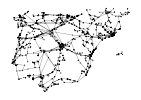

In [56]:
gr_spain, spain_ids = induced_subgraph(gr, findall(@. (36 < gr_latitude < 44) & (-10 < gr_longitude < 4)))
gplot(gr_spain, gr_longitude[spain_ids], -gr_latitude[spain_ids],
      NODESIZE=0.01, nodefillc="black",
      EDGELINEWIDTH=0.2, edgestrokec="black")

## Visualize part of the GitHub (ml) graph

Quite different from the Grid graph, with clumps (dense areas) and less regular edge distribution

In [67]:
cc_ml = connected_components(gh_ml)
giant_ml, giant_ml_idx = induced_subgraph(gh_ml, cc_ml[argmax(length.(cc_ml))])

({7083, 19491} undirected simple Int64 graph, [3, 4, 5, 7, 8, 9, 10, 11, 13, 14  …  9727, 9728, 9729, 9730, 9733, 9734, 9735, 9736, 9737, 9739])

In [83]:
# you can use other layuts if you want to experiment
locs_x, locs_y = spring_layout(giant_ml, MAXITER=5)

([-0.2861580002963987, -0.0800790693688147, 0.07962286379803452, 0.06311019644926485, -0.0506505468958256, 0.1759456507220596, 0.05058651508709833, 0.34641964077145304, 0.15298935020858373, 0.10735412327847116  …  -0.33503858459678615, 0.22805211473786113, 0.44661698960379215, -0.2749723864226117, -0.09568175822908831, 0.15059424187169035, -0.10411445683281928, -0.015025846150784616, -0.6079621815532059, -0.45155222848035503], [-0.0271664510200893, -0.22486377477613761, 0.27649886227165954, 0.42130932808282595, 0.14307759981202572, -0.11779825836381452, 0.3354878729434905, -0.44487443742802557, 0.0673003668684129, -0.12542922257641187  …  0.10469374143605115, 0.47233672124228754, 0.2387400996680864, -0.23366977434578062, 0.37051898629315594, 0.2145214097538124, 0.06638674998778327, 0.039037846855717984, 0.16747956552991594, -0.11186150296894304])

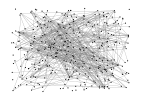

In [86]:
xmin, xmax = quantile(locs_x, [0.4, 0.6])
ymin, ymax = quantile(locs_y, [0.4, 0.6])

ml_zoom, ml_zoom_ids = induced_subgraph(giant_ml, findall(@. (xmin < locs_x < xmax) & (ymin < locs_y < ymax)))
gplot(ml_zoom, locs_x[ml_zoom_ids], locs_y[ml_zoom_ids],
      NODESIZE=0.01, nodefillc="black",
      EDGELINEWIDTH=0.2, edgestrokec="gray")

## Visualize part of the GitHub (web) graph

In [87]:
cc_web = connected_components(gh_web)
giant_web, giant_web_idx = induced_subgraph(gh_web, cc_web[argmax(length.(cc_web))])

({27653, 224611} undirected simple Int64 graph, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  27952, 27953, 27954, 27955, 27956, 27957, 27958, 27959, 27960, 27961])

In [89]:
# you can use other layuts if you want to experiment
locs_x, locs_y = random_layout(giant_web)

([0.8607992324782976, 0.07205875622925983, 0.8784445199827371, 0.9061866638664635, 0.7059866506255574, 0.706611199244704, 0.13528606986813885, 0.06543720216120419, 0.10596665707324537, 0.8716513304359654  …  0.026506586545379518, 0.7956271161297748, 0.2602459712581253, 0.017401316948889134, 0.7134759193808311, 0.0741066376200128, 0.3990895862044168, 0.8869675056666406, 0.3808916592014506, 0.7830866625698722], [0.06532386275854707, 0.035905492311191, 0.46185036622798004, 0.38031911949383557, 0.7429124801613898, 0.43735225240833975, 0.8446601017001669, 0.27504006915067336, 0.2902030018636943, 0.25428964086459227  …  0.24818983450431742, 0.08656372986135419, 0.24003628313126546, 0.7127792279703711, 0.20762161617712005, 0.42251612891517043, 0.01908724528726302, 0.6376741522848717, 0.993315540638902, 0.02970395466903475])

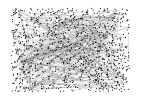

In [98]:
xmin, xmax = quantile(locs_x, [0.1, 0.3])
ymin, ymax = quantile(locs_y, [0.1, 0.3])

web_zoom, web_zoom_ids = induced_subgraph(giant_web, findall(@. (xmin < locs_x < xmax) & (ymin < locs_y < ymax)))
gplot(web_zoom, locs_x[web_zoom_ids], locs_y[web_zoom_ids],
      NODESIZE=0.01, nodefillc="black",
      EDGELINEWIDTH=0.2, edgestrokec="gray")

## Compare degree distributions

We plot the (empirical) cumulative distribution functions (cdf)

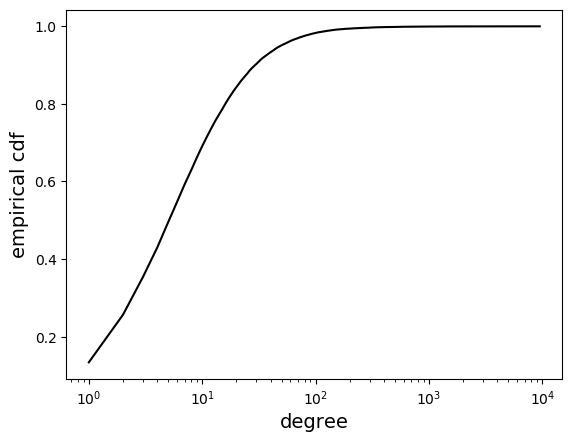

In [113]:
## degree distribution - GitHub graph
deg = degree(gh)
e = ecdf(deg)
x = range(extrema(e)..., step=1)
y = e.(x)
semilogx(x,y,"-",color="black",label="GitHub")
xlabel("degree",fontsize=14)
ylabel("empirical cdf",fontsize=14);

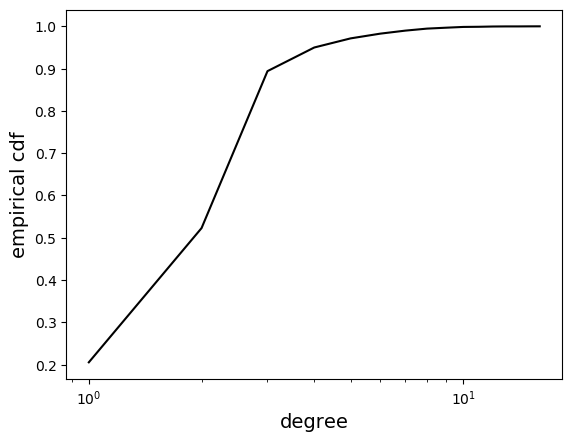

In [114]:
## degree distribution - Grid graph
## we see much lower degree here
deg = degree(gr)
e = ecdf(deg)
x = range(extrema(e)..., step=1)
y = e.(x)
semilogx(x,y,"-",color="black",label="Grid")
xlabel("degree",fontsize=14)
ylabel("empirical cdf",fontsize=14);

## Shortest paths distribution

Histograms of shortest path lengths from 100 random nodes;

again we see much different distributions

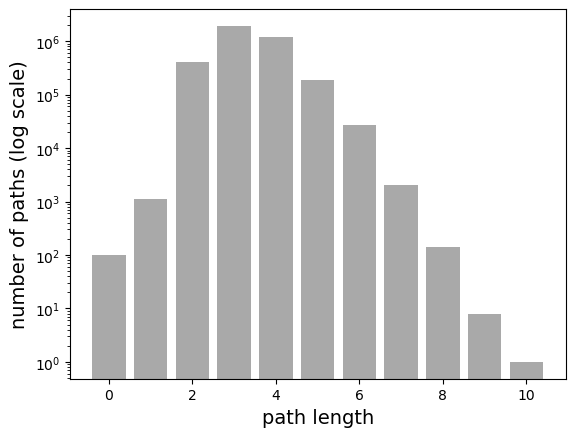

In [124]:
## shortest paths length from a given node, GitHub graph
cc_gh = connected_components(gh)
giant_gh, _ = induced_subgraph(gh, cc_gh[argmax(length.(cc_gh))])
V = sample(1:nv(giant_gh), 100, replace=false)
sp = DataFrame(len=reduce(vcat, gdistances.(Ref(giant_gh), V)))
histdata = combine(groupby(sp, :len, sort=true), nrow => :count)

fig, ax = subplots()
ax.bar(histdata.len, histdata.count, color="darkgrey") 

ax.set_yscale("log")

ax.set_xlabel("path length",fontsize=14)
ax.set_ylabel("number of paths (log scale)",fontsize=14);

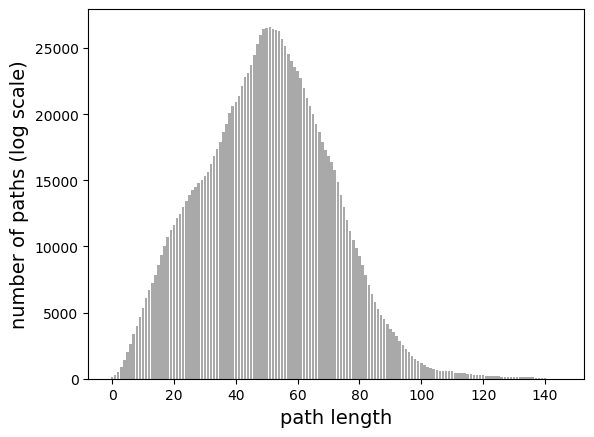

In [10]:
## min path length from that node to other nodes, Grid network
cc_gr = connected_components(gr)
giant_gr, _ = induced_subgraph(gr, cc_gr[argmax(length.(cc_gr))])
V = sample(1:nv(giant_gr), 100, replace=false)
V = 1:100
sp = DataFrame(len=reduce(vcat, gdistances.(Ref(giant_gr), V)))
histdata = combine(groupby(sp, :len, sort=true), nrow => :count)

fig, ax = subplots()
ax.bar(histdata.len, histdata.count, color="darkgrey") 

ax.set_xlabel("path length",fontsize=14)
ax.set_ylabel("number of paths (log scale)",fontsize=14);

## Local clustering coefficient

We compare the average local clustering coefficients as a function
of the degree. We consider degrees from 10 to 1000.


In [29]:
## build dataframe with degrees and local clustering coefficients
## and compute mean values w.r.t. degree.
## GitHub graph
mindeg = 10
maxdeg = 1000

D = DataFrame(CC=local_clustering_coefficient(gh, 1:nv(gh)), d=degree(gh))
D_mean = combine(groupby(D, :d, sort=true), :CC => mean => :CC)
filter!(:d => x -> 10 <= x <= 1000, D_mean)
transform!(D_mean, :d => ByRow(log) => :x, :CC => ByRow(log) => :y)
model = lm(@formula(y~x), D_mean)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y ~ 1 + x

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)   0.534619   0.106995     5.00    <1e-6    0.32414    0.745097
x            -0.715984   0.0206667  -34.64    <1e-99  -0.756639  -0.675329
──────────────────────────────────────────────────────────────────────────

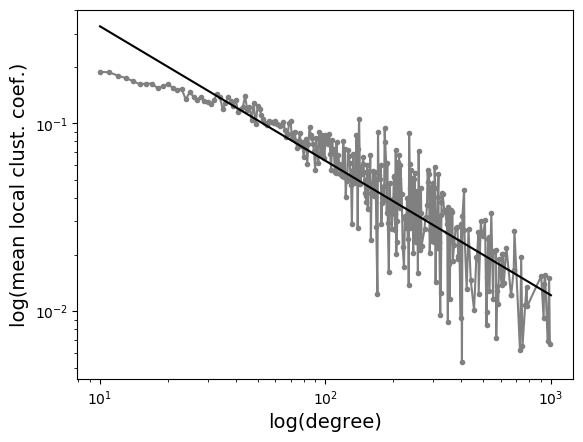

In [30]:
## plot on log-log scale
b, a = coef(model)
loglog(D_mean.d, D_mean.CC,".-",color="grey")
plot([mindeg,maxdeg],[exp(b)*mindeg^a,exp(b)*maxdeg^a],color="black")
xlabel("log(degree)",fontsize=14)
ylabel("log(mean local clust. coef.)",fontsize=14);
#plt.savefig('localCC.eps');